<img src="../images/logos/arm_logo.png" width=500 alt="ARM Logo"></img>

# Py-ART Basics
---

## Overview
   
Within this notebook, we will cover:

1. General overview of Py-ART and its functionality
1. Reading data using Py-ART
1. An overview of the `pyart.Radar` object
1. Create a Plot of our Radar Data


## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Helpful | Basic features |
| [Matplotlib Basics](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Helpful | Basic plotting |
| [NumPy Basics](https://foundations.projectpythia.org/core/numpy/numpy-basics.html) | Helpful | Basic arrays |

- **Time to learn**: 15 minutes
---

## Imports

In [1]:
import os
import warnings

import cartopy.crs as ccrs
import matplotlib.pyplot as plt


import pyart
from pyart.testing import get_test_data

from metpy.plots import USCOUNTIES
from metpy.calc import dewpoint_from_relative_humidity
from metpy.units import units

import cartopy.crs as ccrs
import cartopy.feature as cfeature

warnings.filterwarnings('ignore')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## An Overview of Py-ART

### History of the Py-ART

 * Development began to address the needs of ARM with the acquisition of a number of
   new scanning cloud and precipitation radar as part of the American Recovery Act.
 * The project has since expanded to work with a variety of weather radars and a wider user
   base including radar researchers and climate modelers.
 * The software has been released on GitHub as open source software under a BSD license.
   Runs on Linux, OS X. It also runs on Windows with more limited functionality.

### What can PyART Do?

Py-ART can be used for a variety of tasks from basic plotting to more complex
processing pipelines. Specific uses for Py-ART include:

 * Reading radar data in a variety of file formats.
 * Creating plots and visualization of radar data.
 * Correcting radar moments while in antenna coordinates, such as:
    * Doppler unfolding/de-aliasing.
    * Attenuation correction.
    * Phase processing using a Linear Programming method.
 * Mapping data from one or multiple radars onto a Cartesian grid.
 * Performing retrievals.
 * Writing radial and Cartesian data to NetCDF files.

## Reading in Data Using Py-ART

### Reading data in using `pyart.io.read`

When reading in a radar file, we use the `pyart.io.read` module.

`pyart.io.read` can read a variety of different radar formats, such as Cf/Radial, LASSEN, and more. 
The documentation on what formats can be read by Py-ART can be found here:

* [Py-ART IO Documentation](https://arm-doe.github.io/pyart/API/generated/pyart.io.html)

For most file formats listed on the page, using `pyart.io.read` should suffice since Py-ART has the ability to automatically detect the file format.

Let's check out what arguments arguments `pyart.io.read()` takes in!

In [2]:
pyart.io.read?

Signature: pyart.io.read(filename, use_rsl=False, **kwargs)
Docstring:
Read a radar file and return a radar object.

Additional parameters are passed to the underlying read_* function.

Parameters
----------
filename : str
    Name of radar file to read.
use_rsl : bool
    True will use the TRMM RSL library to read files which are supported
    both natively and by RSL. False will choose the native read function.
    RSL will always be used to read a file if it is not supported
    natively.

Other Parameters
-------------------
field_names : dict, optional
    Dictionary mapping file data type names to radar field names. If a
    data type found in the file does not appear in this dictionary or has
    a value of None it will not be placed in the radar.fields dictionary.
    A value of None, the default, will use the mapping defined in the
    metadata configuration file.
additional_metadata : dict of dicts, optional
    Dictionary of dictionaries to retrieve metadata from during this

Let's use a sample data file from `pyart` - which is [**cfradial** format](https://github.com/NCAR/CfRadial).

When we read this in, we get a [`pyart.Radar` object](https://arm-doe.github.io/pyart/API/generated/pyart.core.Radar.html#pyart.core.Radar)!

## Read NEXRAD Level 2 Data
Let’s start first with NEXRAD Level 2 data, which is ground-based radar data collected by the National Oceanic and Atmospheric Administration (NOAA), as a part of the National Weather Service 
### Configure our Filepath for NEXRAD Level 2 Data We will access data from the noaa-nexrad-level2 bucket, with the data organized as: 
https://noaa-nexrad-level2.s3.amazonaws.com/index.html#2024/04/04/KTYX/

In [3]:
file = "data/KTYX20240404_060315_V06"
radar = pyart.io.read(file)
radar

### Investigate the [`pyart.Radar` object](https://arm-doe.github.io/pyart/API/generated/pyart.core.Radar.html#pyart.core.Radar)

Within this [`pyart.Radar` object](https://arm-doe.github.io/pyart/API/generated/pyart.core.Radar.html#pyart.core.Radar) object are the actual data fields.

This is where data such as reflectivity and velocity are stored.

To see what fields are present we can add the fields and keys additions to the variable where the radar object is stored.

In [4]:
radar.fields.keys()

dict_keys(['differential_reflectivity', 'cross_correlation_ratio', 'velocity', 'differential_phase', 'spectrum_width', 'reflectivity', 'clutter_filter_power_removed'])

In [5]:
reflectivity = radar.fields['reflectivity']['data']
print(type(reflectivity), reflectivity)

<class 'numpy.ma.core.MaskedArray'> [[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [12.5 14.0 12.5 ... -- -- --]
 [12.5 14.5 15.5 ... -- -- --]
 [14.5 15.5 10.0 ... -- -- --]]


Lets' check the size of this array...

In [6]:
reflectivity.shape

(6840, 1832)

This reflectivity data array, numpy array, is a two-dimensional array with dimensions:
- Gates (number of samples away from the radar)
- Rays (direction around the radar)

In [7]:
print(radar.nrays, radar.ngates)

6840 1832


If we wanted to look the 300th ray, at the second gate, we would use something like the following:

In [8]:
print(reflectivity[300, 2])

12.0


## Plotting our Radar Data

### An Overview of Py-ART Plotting Utilities

Now that we have loaded the data and inspected it, the next logical thing to do is to visualize the data! Py-ART's visualization functionality is done through the objects in the [pyart.graph](https://arm-doe.github.io/pyart/API/generated/pyart.graph.html) module.

In Py-ART there are 4 primary visualization classes in pyart.graph:

* [RadarDisplay](https://arm-doe.github.io/pyart/API/generated/pyart.graph.RadarDisplay.html)
* [RadarMapDisplay](https://arm-doe.github.io/pyart/API/generated/pyart.graph.RadarMapDisplay.html)
* [AirborneRadarDisplay](https://arm-doe.github.io/pyart/API/generated/pyart.graph.AirborneRadarDisplay.html)

Plotting grid data
* [GridMapDisplay](https://arm-doe.github.io/pyart/API/generated/pyart.graph.GridMapDisplay.html)

### Use the [RadarMapDisplay](https://arm-doe.github.io/pyart/API/generated/pyart.graph.RadarMapDisplay.html) with our data

For the this example, we will be using `RadarMapDisplay`, using Cartopy to deal with geographic coordinates.


We start by creating a figure first.

In [9]:
fig = plt.figure(figsize=[10, 10])

<Figure size 1000x1000 with 0 Axes>

Once we have a figure, let's add our `RadarMapDisplay`

In [10]:
fig = plt.figure(figsize=[10, 10])
display = pyart.graph.RadarMapDisplay(radar)

<Figure size 1000x1000 with 0 Axes>

Adding our map display without specifying a field to plot **won't do anything** we need to specifically add a field to field using `.plot_ppi_map()`

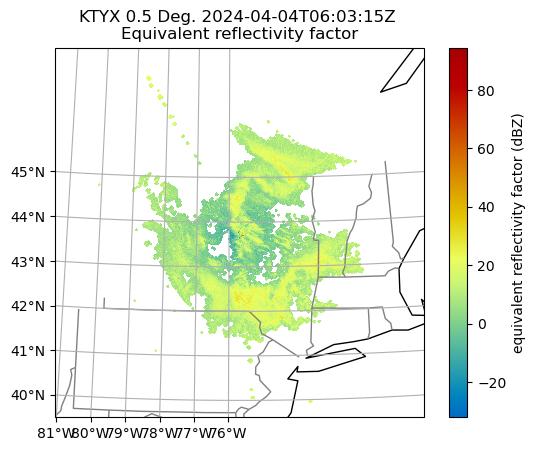

In [11]:
display.plot_ppi_map('reflectivity')

By default, it will plot the elevation scan, the the default colormap from `Matplotlib`... let's customize!

We add the following arguements:
- `sweep=3` - The fourth elevation scan (since we are using Python indexing)
- `vmin=-20` - Minimum value for our plotted field/colorbar
- `vmax=60` - Maximum value for our plotted field/colorbar
- `projection=ccrs.PlateCarree()` - Cartopy latitude/longitude coordinate system
- `cmap='pyart_ChaseSpectral'` - Colormap to use, selecting one provided by PyART 

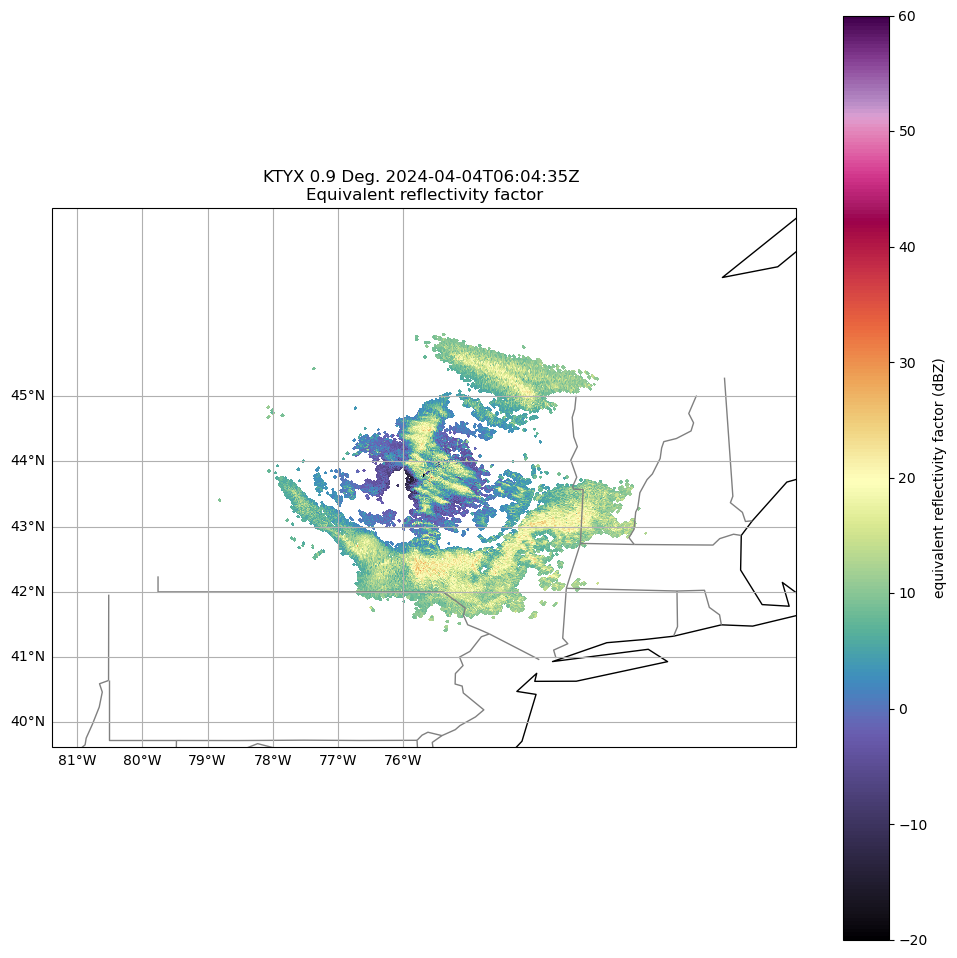

In [12]:
fig = plt.figure(figsize=[12, 12])
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map('reflectivity',
                     sweep=3,
                     vmin=-20,
                     vmax=60,
                     projection=ccrs.PlateCarree(),
                     cmap='pyart_ChaseSpectral')
plt.show()

You can change many parameters in the graph by changing the arguments to plot_ppi_map. As you can recall from earlier. simply view these arguments in a Jupyter notebook by typing:

In [13]:
display.plot_ppi_map?

Signature:
display.plot_ppi_map(
    field,
    sweep=0,
    mask_tuple=None,
    vmin=None,
    vmax=None,
    cmap=None,
    norm=None,
    mask_outside=False,
    title=None,
    title_flag=True,
    colorbar_flag=True,
    colorbar_label=None,
    colorbar_orient='vertical',
    ax=None,
    fig=None,
    lat_lines=None,
    lon_lines=None,
    projection=None,
    min_lon=None,
    max_lon=None,
    min_lat=None,
    max_lat=None,
    width=None,
    height=None,
    lon_0=None,
    lat_0=None,
    resolution='110m',
    shapefile=None,
    shapefile_kwargs=None,
    edges=True,
    gatefilter=None,
    filter_transitions=True,
    embellish=True,
    add_grid_lines=True,
    raster=False,
    ticks=None,
    ticklabs=None,
    alpha=None,
    edgecolors='face',
    **kwargs,
)
Docstring:
Plot a PPI volume sweep onto a geographic map.

Parameters
----------
field : str
    Field to plot.
sweep : int, optional
    Sweep number to plot.

Other Parameters
----------------
mask_tuple 

For example, let's change the minimum / maximum latitude and longitude of the display

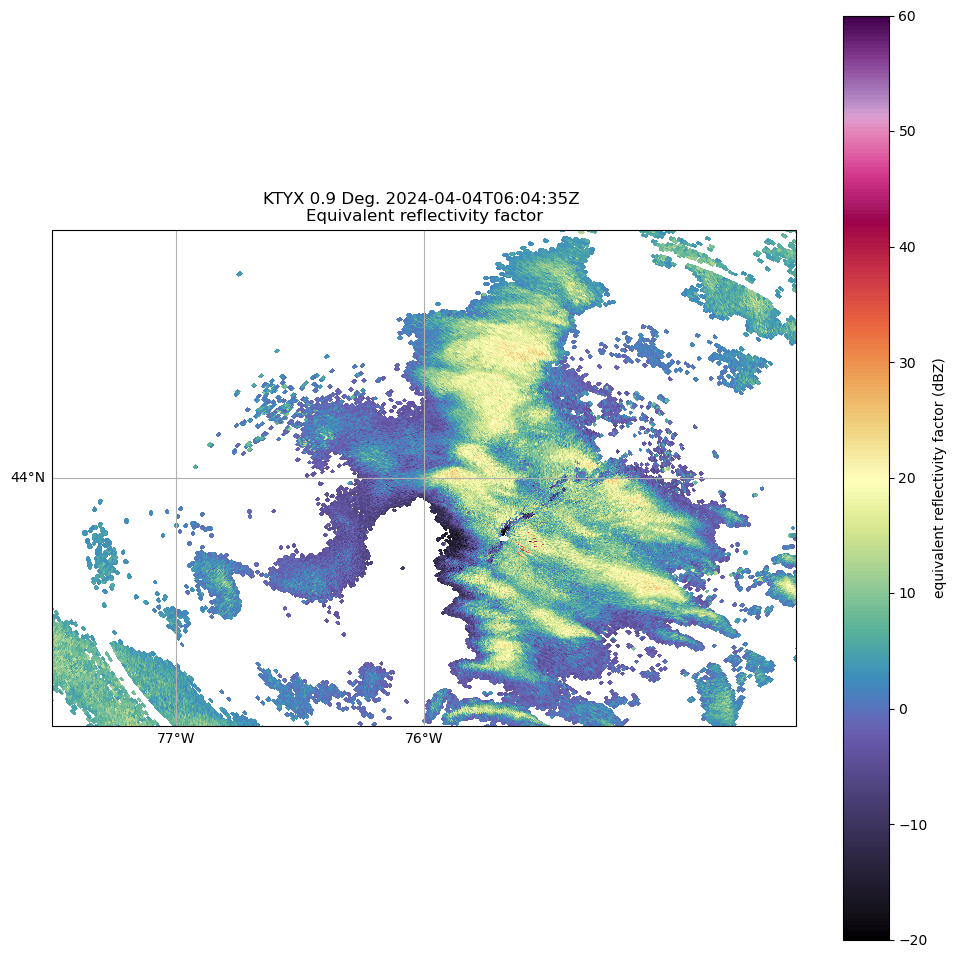

In [14]:
bounds = [43.0, 45.0, -77.5, -74.5]

fig = plt.figure(figsize=[12, 12])
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map('reflectivity',
                     sweep=3,
                     vmin=-20,
                     vmax=60,
                     min_lat=bounds[0],
                     max_lat=bounds[1],
                     min_lon=bounds[2],
                     max_lon=bounds[3],
                     projection=ccrs.PlateCarree(),
                     cmap='pyart_ChaseSpectral')
plt.show()

## Let's add some counties to figure out where we are

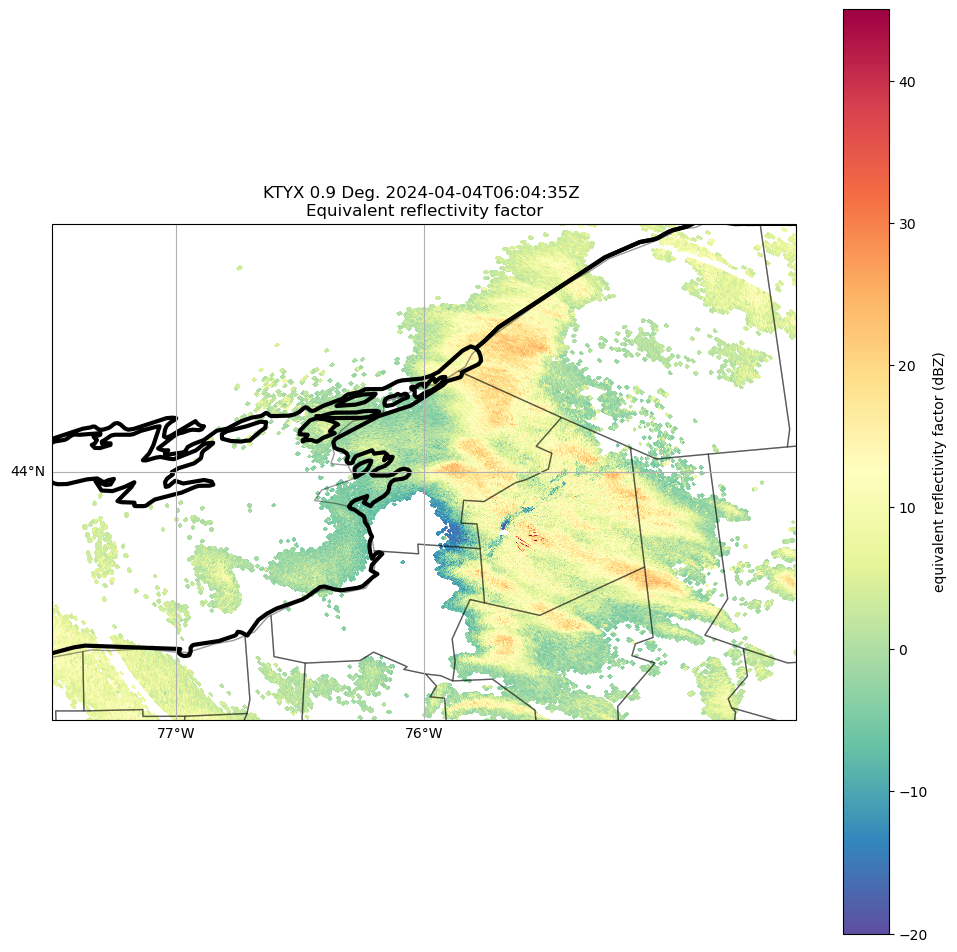

In [16]:
#-------------------
# Plot the Radar PPI
#-------------------
bounds = [43.0, 45.0, -77.5, -74.5]

fig = plt.figure(figsize=[12, 12])
ax1 = fig.add_subplot(111, projection=ccrs.PlateCarree())
#ax1 = fig.add_subplot(111)

ax1.add_feature(cfeature.STATES, linewidth=3)
ax1.add_feature(USCOUNTIES, alpha=0.4)

# Create the Radar Display Object
display = pyart.graph.RadarMapDisplay(radar)

# Plot the reflectivty
display.plot_ppi_map('reflectivity', 
                     ax=ax1,
                     sweep=3, 
                     vmin=-20,
                     vmax=45,
                     min_lat=bounds[0],
                     max_lat=bounds[1],
                     min_lon=bounds[2],
                     max_lon=bounds[3],
                     embellish=False,
                     norm=None,
                     cmap="Spectral_r")

---
## Summary
Within this notebook, we covered the basics of working with radar data using `pyart`, including:
- Reading in a file using `pyart.io`
- Investigating the `Radar` object
- Visualizing radar data using the `RadarMapDisplay`

### What's Next
In the next few notebooks, we walk through gridding radar data, applying data cleaning methods, and advanced visualization methods!

## Resources and References
Py-ART essentials links:

* [Landing page](https://arm-doe.github.io/pyart/)
* [Examples](https://arm-doe.github.io/pyart/examples/index.html)
* [Source Code](https://github.com/ARM-DOE/pyart)
* [Open Radar Discourse Group](https://openradar.discourse.group/)
* [Issue Tracker](https://github.com/ARM-DOE/pyart/issues)